In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-labelled-sentences-data-set/amazon_cells_labelled.txt
/kaggle/input/sentiment-labelled-sentences-data-set/imdb_labelled.txt
/kaggle/input/sentiment-labelled-sentences-data-set/yelp_labelled.txt


In [2]:
%%capture
!pip install contractions

In [3]:
import nltk
import string
import random
import re
import contractions
import warnings

import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.feature_extraction import text as text_learn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn import metrics, naive_bayes
from sklearn import ensemble, linear_model, tree, decomposition
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

fig_size = plt.rcParams['figure.figsize']
eng_stopwords = set(stopwords.words('english'))
warnings.filterwarnings('ignore')

%matplotlib inline

In [4]:
def process(text:str):
    text = contractions.fix(text)
    text = text.translate(str.maketrans({key: f" {key} " for key in string.punctuation}))
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.lower()
    text = text.split()
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in text]
    text = " ".join(lemmatized_words)

    return text

In [5]:
df_list = [pd.read_csv(os.path.join(dirname, filename), sep='\t', header=None, names=["Sentence", "Sentiment"]) for filename in filenames]
df = pd.concat(df_list, ignore_index=True)
df

,Sentence,Sentiment
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1
...,...,...
2743,I think food should have flavor and texture an...,0
2744,Appetite instantly gone.,0
2745,Overall I was not impressed and would not go b...,0
2746,"The whole experience was underwhelming, and I ...",0


In [6]:
df["processed_sentence"] = df.Sentence.apply(process)
df

,Sentence,Sentiment,processed_sentence
0,So there is no way for me to plug it in here i...,0,so there is no way for me to plug it in here i...
1,"Good case, Excellent value.",1,good case excellent value
2,Great for the jawbone.,1,great for the jawbone
3,Tied to charger for conversations lasting more...,0,tied to charger for conversation lasting more ...
4,The mic is great.,1,the mic is great
...,...,...,...
2743,I think food should have flavor and texture an...,0,i think food should have flavor and texture an...
2744,Appetite instantly gone.,0,appetite instantly gone
2745,Overall I was not impressed and would not go b...,0,overall i wa not impressed and would not go back
2746,"The whole experience was underwhelming, and I ...",0,the whole experience wa underwhelming and i th...


In [7]:
df_train, df_val = train_test_split(df[["processed_sentence", "Sentiment"]], stratify=df.Sentiment, test_size=0.2)

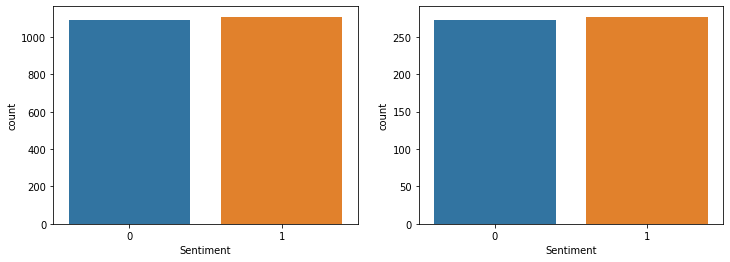

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(fig_size[0] * 2, fig_size[1] * 1))
_ = sns.countplot(df_train.Sentiment, ax=ax[0])
_ = sns.countplot(df_val.Sentiment, ax=ax[1])

In [9]:
tfpipe = Pipeline([
    ('tfidf', text_learn.TfidfVectorizer()),
    ('logistic_regression', linear_model.LogisticRegression(max_iter=250))
])

param_grid = {
    'logistic_regression__C': np.logspace(-2, 3, base=2, num=15).tolist() + np.logspace(-2, 3, base=10, num=15).tolist(),
    'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2), (1, 3)]
}

model_grid = GridSearchCV(tfpipe, param_grid)
model_grid.fit(df_train.processed_sentence, df_train.Sentiment)

GridSearchCV(estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('logistic_regression',
                                        LogisticRegression(max_iter=250))]),
             param_grid={'logistic_regression__C': [0.25, 0.32022167244106814,
                                                    0.410167678003819,
                                                    0.5253783193266097,
                                                    0.6729500963161781,
                                                    0.8619728212469778,
                                                    1.1040895136738123,
                                                    1.4142135623730951,
                                                    1.8114473285278134,
                                                    2.320258772320326,
                                                    2.971988578...
                                                    3.806780612042479,


In [10]:
best_model_tf = model_grid.best_estimator_
model_grid.best_params_

{'logistic_regression__C': 1000.0, 'tfidf__ngram_range': (1, 3)}

Accuracy: 85.27%
Precision: 0.853
Recall: 0.856
F1 Score: 0.854
AUC: 0.928


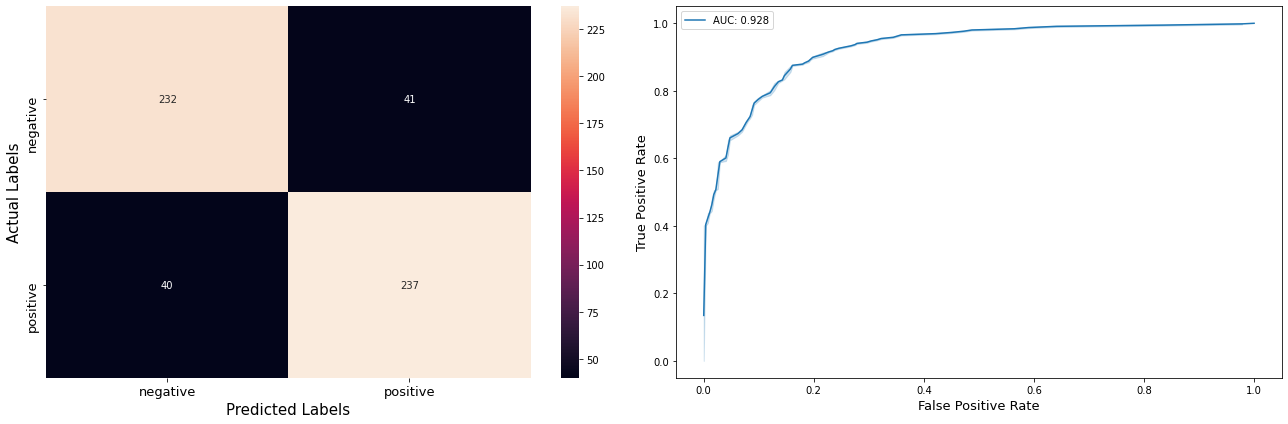

In [11]:
y_true = df_val.Sentiment.values
y_pred = best_model_tf.predict(df_val.processed_sentence.values)
y_pred_proba = best_model_tf.predict_proba(df_val.processed_sentence.values)[:, 1]

# compute metrics on validation set
accuracy = (y_pred == y_true).sum() / df_val.shape[0]
conf_matrix = metrics.confusion_matrix(y_true, y_pred)
precision = metrics.precision_score(y_true, y_pred)
recall = metrics.recall_score(y_true, y_pred)
f1_score = metrics.f1_score(y_true, y_pred)
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred_proba)
auc_score = metrics.auc(fpr, tpr)

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1_score:.3f}")
print(f"AUC: {auc_score:.3f}")

nrows = 1
ncols = 2
fig, ax = plt.subplots(nrows, ncols, figsize=(fig_size[0] * 1.5 * ncols, fig_size[1] * 1.5 * nrows))
_ = sns.heatmap(conf_matrix, annot=True, fmt='d', ax=ax[0])
_ = ax[0].set_xticklabels(["negative", "positive"], fontsize=13)
_ = ax[0].set_yticklabels(["negative", "positive"], fontsize=13)
_ = ax[0].set_xlabel("Predicted Labels", fontsize=15)
_ = ax[0].set_ylabel("Actual Labels", fontsize=15)
_ = sns.lineplot(fpr, tpr, ax=ax[1], label=f"AUC: {auc_score:.3f}")
_ = ax[1].set_xlabel("False Positive Rate", fontsize=13)
_ = ax[1].set_ylabel("True Positive Rate", fontsize=13)
_ = plt.tight_layout()

In [12]:
pipe = Pipeline([
    ('bow', text_learn.CountVectorizer()),
    ('logistic_regression', linear_model.LogisticRegression(max_iter=250))
])

param_grid = {
    'logistic_regression__C': np.logspace(-2, 3, base=2, num=15).tolist() + np.logspace(-2, 3, base=10, num=15).tolist(),
    'bow__ngram_range': [(1, 1), (1, 2), (2, 2), (1, 3)]
}

model_grid = GridSearchCV(pipe, param_grid)
model_grid.fit(df_train.processed_sentence, df_train.Sentiment)

GridSearchCV(estimator=Pipeline(steps=[('bow', CountVectorizer()),
                                       ('logistic_regression',
                                        LogisticRegression(max_iter=250))]),
             param_grid={'bow__ngram_range': [(1, 1), (1, 2), (2, 2), (1, 3)],
                         'logistic_regression__C': [0.25, 0.32022167244106814,
                                                    0.410167678003819,
                                                    0.5253783193266097,
                                                    0.6729500963161781,
                                                    0.8619728212469778,
                                                    1.1040895136738123,
                                                    1.4142135623730951,
                                                    1.811...
                                                    2.320258772320326,
                                                    2.9719885782738973,


In [13]:
best_model = model_grid.best_estimator_
model_grid.best_params_

{'bow__ngram_range': (1, 2), 'logistic_regression__C': 1000.0}

Accuracy: 85.27%
Precision: 0.855
Recall: 0.852
F1 Score: 0.854
AUC: 0.916


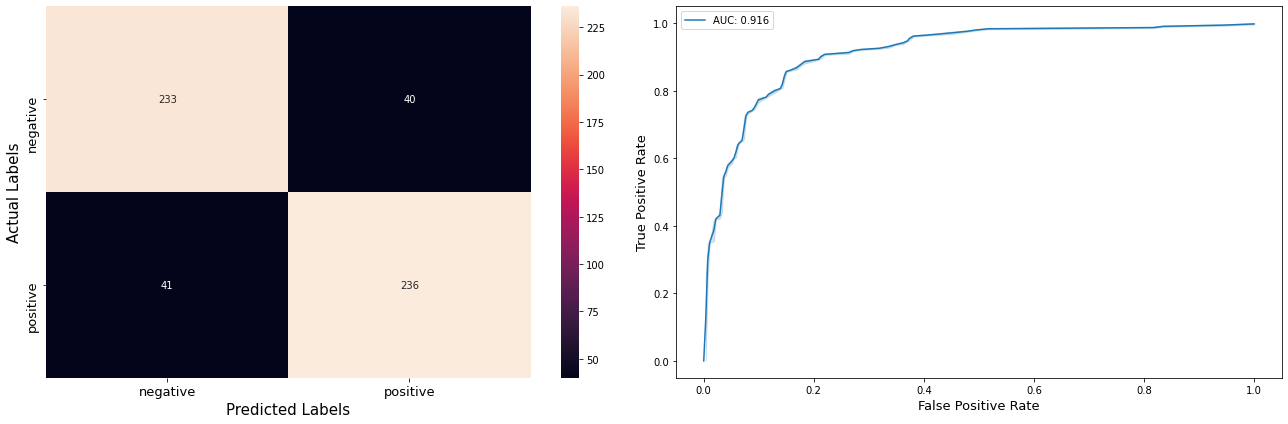

In [14]:
y_true = df_val.Sentiment.values
y_pred = best_model.predict(df_val.processed_sentence.values)
y_pred_proba = best_model.predict_proba(df_val.processed_sentence.values)[:, 1]

# compute metrics on validation set
accuracy = (y_pred == y_true).sum() / df_val.shape[0]
conf_matrix = metrics.confusion_matrix(y_true, y_pred)
precision = metrics.precision_score(y_true, y_pred)
recall = metrics.recall_score(y_true, y_pred)
f1_score = metrics.f1_score(y_true, y_pred)
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred_proba)
auc_score = metrics.auc(fpr, tpr)

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1_score:.3f}")
print(f"AUC: {auc_score:.3f}")

nrows = 1
ncols = 2
fig, ax = plt.subplots(nrows, ncols, figsize=(fig_size[0] * 1.5 * ncols, fig_size[1] * 1.5 * nrows))
_ = sns.heatmap(conf_matrix, annot=True, fmt='d', ax=ax[0])
_ = ax[0].set_xticklabels(["negative", "positive"], fontsize=13)
_ = ax[0].set_yticklabels(["negative", "positive"], fontsize=13)
_ = ax[0].set_xlabel("Predicted Labels", fontsize=15)
_ = ax[0].set_ylabel("Actual Labels", fontsize=15)
_ = sns.lineplot(fpr, tpr, ax=ax[1], label=f"AUC: {auc_score:.3f}")
_ = ax[1].set_xlabel("False Positive Rate", fontsize=13)
_ = ax[1].set_ylabel("True Positive Rate", fontsize=13)
_ = plt.tight_layout()